## Secondary Study to Evaluate Park Density and Air Quality As Predictors to Median Rent Prices in Los Angeles

* Data acquired from USC.Data.socratas
* Major Steps
* 1 Air Quality Data set
* 2 Park Count Data set
* 3 Merge Data
* 4 Model Validation and Statistical Analysis
* How does down sampling alter estimated and cummulative distribution functions
* Are the means for the down sampled and original data sets different? T-test independent samples.



# Parto 1: Air quality study
### Set-up Dependencies
* API call to get data
* Prepare pandas dataframe
* Exploritory data analysis

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import gmaps
import seaborn as sns
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy.stats import ttest_ind, ttest_ind_from_stats, levene


# Google developer API key
from config import gkey

# Configure gmaps
gmaps.configure(api_key=gkey)


### Set-up Multi-API Call
* This data set has 2 years available, so I will create two API calls and add all the date into a single datafram

In [2]:
# The data has 2 years
years = [2014, 2017]
# The endpoint will require I specify the year
url =  "https://usc.data.socrata.com/resource/bhyw-mxf5.json?$where=year="

### Save JSON data into Lists (pre-dataframe step)

In [3]:
# Initialize a list that will eventually be used for form the columns in dataframe.
count = []
dataset = []
date = []
geoid = []
location = []
lat = []
lng = []
neighborhood = []
policy_area = []
row_id = []
tract = []
tract_number = []
variable = []
year = []


for yr in years:
    query_url = f"{url}{yr}"
    response = requests.get(query_url)
    response_json = response.json()
    
    for key in range(len(response_json)):
        count.append(response_json[key]['count'])
        dataset.append(response_json[key]['dataset'])
        date.append(response_json[key]['date'])
        geoid.append(response_json[key]['geoid'])
        location.append(response_json[key]['location'])
        neighborhood.append(response_json[key]['neighborhood'])
        policy_area.append(response_json[key]['policy_area'])
        row_id.append(response_json[key]['row_id'])
        tract.append(response_json[key]['tract'])
        tract_number.append(response_json[key]['tract_number'])
        variable.append(response_json[key]['variable'])
        year.append(response_json[key]['year'])




### Split location column into lat and lng columns
* Having lat and logitudinal data will be useful for map visualization

In [4]:
# Split the location list into two lists, one for lat and one for long data
for i in range(len(location)):
    first = location[i].index(location[i][1])
    last = location[i].index(location[i][-1])
    unpacked = location[i][first:last]
    split_location = unpacked.split(",")
    lat.append(split_location[0])
    lng.append(split_location[1])


### Create Dataframe
* Create a dictionary that contains the list of data from the JSON data, and a label
* Pass the dict object into pd.DataFrame, and create a pandas object

In [5]:
dict = {"year" : year,
        "count" : count,
       "dataset" : dataset,
       "date" :  date,
       "geoid" : geoid,
       "location" : location,
        "lat" : lat,
        "lng" : lng,
        "neighborhood" : neighborhood,
        "policy area" : policy_area,
        "row id": row_id,
        "tract" : tract,
        "tract number" : tract_number,
        "variable" : variable,
       }

df = pd.DataFrame(data = dict)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 14 columns):
year            2000 non-null object
count           2000 non-null object
dataset         2000 non-null object
date            2000 non-null object
geoid           2000 non-null object
location        2000 non-null object
lat             2000 non-null object
lng             2000 non-null object
neighborhood    2000 non-null object
policy area     2000 non-null object
row id          2000 non-null object
tract           2000 non-null object
tract number    2000 non-null object
variable        2000 non-null object
dtypes: object(14)
memory usage: 218.8+ KB


### Format and Clean Data for Further Analysis
* Convert columns to appropriate data types
* For data imported as strings, remove white space, and misc characters.


In [6]:
# Convert the following column from string to floats. 
# The count column contains pollution data.
# Location, lat and lng to be used for mapping and other analysis

df["count"] = pd.to_numeric(df["count"])
df["lat"] = pd.to_numeric(df["lat"])
df["lng"] = pd.to_numeric(df["lng"])

df.head()

,year,count,dataset,date,geoid,location,lat,lng,neighborhood,policy area,row id,tract,tract number,variable
0,2014,11.040100,Air Quality,2014-01-01T00:00:00.000,1400000US06037101110,"(34.2595555, -118.293602)",34.259555,-118.293602,Tujunga,Environment,PM2.5_Concentration_2014_1400000US06037101110,"Census Tract 1011.10, Los Angeles County, Cali...",101110,PM2.5 Concentration
1,2014,10.953724,Air Quality,2014-01-01T00:00:00.000,1400000US06037101122,"(34.267357, -118.29024)",34.267357,-118.290240,Tujunga,Environment,PM2.5_Concentration_2014_1400000US06037101122,"Census Tract 1011.22, Los Angeles County, Cali...",101122,PM2.5 Concentration
2,2014,11.114240,Air Quality,2014-01-01T00:00:00.000,1400000US06037101210,"(34.251998, -118.2926875)",34.251998,-118.292687,Tujunga,Environment,PM2.5_Concentration_2014_1400000US06037101210,"Census Tract 1012.10, Los Angeles County, Cali...",101210,PM2.5 Concentration
3,2014,11.143084,Air Quality,2014-01-01T00:00:00.000,1400000US06037101220,"(34.2511895, -118.281014)",34.251190,-118.281014,Tujunga,Environment,PM2.5_Concentration_2014_1400000US06037101220,"Census Tract 1012.20, Los Angeles County, Cali...",101220,PM2.5 Concentration
4,2014,11.189527,Air Quality,2014-01-01T00:00:00.000,1400000US06037101300,"(34.2455945, -118.271731)",34.245595,-118.271731,Tujunga,Environment,PM2.5_Concentration_2014_1400000US06037101300,"Census Tract 1013, Los Angeles County, California",101300,PM2.5 Concentration


### Visualize Data using Gmaps

In [7]:
# Store latitude and longitude in locations
locations = df[["lat", "lng"]]

# Plot Heatmap
fig = gmaps.figure()

symbol_layer = gmaps.symbol_layer(locations, fill_color='red', stroke_color='black', scale=2)

# Add layer
fig.add_layer(symbol_layer)

# Display figure
fig

Figure(layout=FigureLayout(height='420px'))

##  Aggregate Data by Year and then remove multilevel index

In [8]:
# Aggregate by neighborhood and generate columns for lat, long, and pollution counts.
aggregated_data = df.groupby("neighborhood").agg(["min", "max", "mean"])

air_agg_level_0 = aggregated_data.columns.get_level_values(0)
air_agg_level_1 = aggregated_data.columns.get_level_values(1)

# Remove multilevel index and assign to same df
aggregated_data.columns = air_agg_level_0 + '_' + air_agg_level_1
aggregated_data = aggregated_data[["count_mean", "lat_min", "lng_min"]]
pollution_mean = aggregated_data["count_mean"]
neighborhood_lat = aggregated_data["lat_min"]
neighborhood_lng = aggregated_data["lng_min"]

### Determine the relationship between latitude and pollution counts

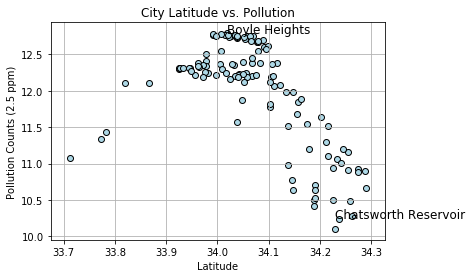

In [9]:
# Plot the pollution counts by neighborhood (via their lat) and visualize in gmaps
x = neighborhood_lat
y = pollution_mean
plt.scatter(x, y, c = 'lightblue', edgecolors = "black")
plt.xlabel("Latitude")
plt.ylabel("Pollution Counts (2.5 ppm)")
plt.title(f"City Latitude vs. Pollution")
plt.grid(True)

# Label the neighborhood with the heighest and lowest counts
# X,Y Coordinates for BH and Chatsworth reservoice
boyle_heights_lat = 34.018117
boyle_heights_cnt = 12.791653
chatsworth_res_lat = 34.228206
chatsworth_res_cnt = 10.245630
plt.text(x = boyle_heights_lat, y = boyle_heights_cnt, s = "Boyle Heights", fontsize = 12)
plt.text(chatsworth_res_lat, chatsworth_res_cnt, s = "Chatsworth Reservoir", fontsize = 12)
plt.savefig('lat_vs_pollution.png')


### Determine the Covariance
* Use numpy np.cov() to evaluate
* a) how the temperature and latitude vary together
* b) determine the directionality of any association
* Statistical Principal:
* The covariance is used to determine the direction of a linear relationship between two variables as follows:
* If both variables tend to increase or decrease together, the coefficient is positive.
* If one variable tends to increase as the other decreases, the coefficient is negative.

In [10]:
x = neighborhood_lat
y = pollution_mean

np.cov(x,y)

# Compute the covariance matrix: covariance_matrix
covariance_matrix = np.cov(x, y)
covariance_matrix

# Extract covariance of latitude and Max Temperature
pol_lav_covariance = covariance_matrix[0,1]
pol_lav_covariance

if (pol_lav_covariance < 0):
    print(f"The covariance for latitude and temperature is {round(pol_lav_covariance,4)}, and is negative. \nThis states that as one variable increases, the other decreases.")
else:
    print(f"The covariance for latitude and temperature is {round(pol_lav_covariance,4)}, is positive. \nThis states that these variable tend to either increase or decrease together.")

The covariance for latitude and temperature is -0.0482, and is negative. 
This states that as one variable increases, the other decreases.


### Determine the Pearson Coefficient
* Use numpy np.corrcoef() to evaluate 
* a) how the temperature and latitude vary together
* b) Examine the linear relationship between these two variables 

* Statistical Principal: 
* Pearson correlation coefficient, also called the Pearson r, is often easier to interpret than the covariance.
* The strenght of the association depends on how close the value approaches -1 or 1.
* The directionality of the association depends on whether it is positive or negative.

In [11]:
# Function that Computes the Pearson correlation coefficient between two arrays.
def pearson_r(x, y):

    # Compute correlation matrix: corr_mat
    corr_mat = np.corrcoef(x, y)

    # Return entry [0,1]
    return corr_mat[0,1]

# Compute Pearson correlation coefficient for I. versicolor: r
r = pearson_r(x, y)

# Print the result
print(r)

if (r < 0):
    print(f"Since r = {round(r,4)}, is negative; as one variable increases, the other decreases.")
    if(r <= -0.75):
        print(f"Since r = {round(r,4)} is close to -1; There is a strong inverse relationship between these two variables.")
if (r > 0):
    print(f"Since r = {round(r,4)}, is positive; both variables increase together, or decrease together.")
    if (r >= 0.75):
        print(f"Since r = {round(r,4)} is close to 1; There is a strong positive relationship between these two variables.")
    else:
        print("There is a weak or no association between both variables.")

-0.5914960694899909
Since r = -0.5915, is negative; as one variable increases, the other decreases.


### Visualize 5 neighborhoods with the higest and lowest pollution and plot in gmap

In [12]:
# Top 5 cities with the heighest pollutio using "nlargest"
top_5_pollution = aggregated_data.nlargest(5, "count_mean")
low_5_pollution = aggregated_data.nsmallest(5, "count_mean")
low_5_pollution

,count_mean,lat_min,lng_min
neighborhood,,,
Chatsworth Reservoir,10.100556,34.228206,-118.645614
Chatsworth,10.231992,34.237392,-118.648833
Porter Ranch,10.280580,34.262049,-118.562083
West Hills,10.419982,34.188342,-118.655217
Granada Hills,10.478734,34.257483,-118.524711


In [13]:

# Further subset the lat and lng for each of these cities and save into a new df
top_5_loc = top_5_pollution[["lat_min", "lng_min"]]
low_5_loc = low_5_pollution[["lat_min", "lng_min"]]

In [14]:
# Store latitude and longitude in locations
top_locations = top_5_loc
low_locations = low_5_loc

# Plot Heatmap
fig = gmaps.figure()

# Create heat layer
top_layer = gmaps.heatmap_layer(top_locations)
top_marker_layer = gmaps.marker_layer(top_locations, label='high')

low_layer = gmaps.heatmap_layer(low_locations)
low_marker_layer = gmaps.marker_layer(low_locations, label='low')

# Add layer
fig.add_layer(top_layer)
fig.add_layer(top_marker_layer)
fig.add_layer(low_layer)
fig.add_layer(low_marker_layer)

# Display figure
fig

Figure(layout=FigureLayout(height='420px'))

### Visualize the counts in gmaps to highlight distribution of pollution

In [15]:
# Assign the lat and long variable of the aggregated dataset to the location variable
location = aggregated_data[["lat_min", "lng_min"]]

# Plot Heatmap
locations = location
weights = pollution_mean

fig = gmaps.figure(map_type="SATELLITE")

# # Create heat layer
heat_layer = gmaps.heatmap_layer(locations, weights = weights)

# # Add layer
fig.add_layer(heat_layer)

# # Display figure
fig

Figure(layout=FigureLayout(height='420px'))

# Part 2: Acces to Parks in LA county (1 acre per 1000 residents)
### Set-up Dependencies
* API call to get data
* Prepare pandas dataframe
* Exploritory data analysis

In [16]:
park_url =  "https://usc.data.socrata.com/resource/kp5h-fmqh.json?dataset=Parks Access"

In [17]:
park_count = []
park_dataset = []
park_date = []
park_geoid = []
park_location = []
park_lat = []
park_lng = []
park_neighborhood = []
park_policy_area = []
park_row_id = []
park_tract = []
park_tract_number = []
park_variable = []
park_year = []


query_url_park = f"{park_url}"
response = requests.get(query_url_park)
park_response_json = response.json()
# park_response_json[0:10]

for index in range(len(park_response_json)):
    try:
        park_count.append(park_response_json[index]['count'])
        park_dataset.append(park_response_json[index]['dataset'])
        park_date.append(park_response_json[index]['date'])
        park_geoid.append(park_response_json[index]['geoid'])
        park_location.append(park_response_json[index]['location']['coordinates'])
        park_neighborhood.append(park_response_json[index]['neighborhood'])
        park_policy_area.append(park_response_json[index]['policy_area'])
        park_row_id.append(park_response_json[index]['row_id'])
        park_tract.append(park_response_json[index]['tract'])
        park_tract_number.append(park_response_json[index]['tract_number'])
        park_variable.append(park_response_json[index]['variable'])
        park_year.append(park_response_json[index]['year'])
    except: 
        print(f"this {index} is no good")




this 440 is no good
this 847 is no good


In [18]:
for i in range(len(park_location)):
    park_lat.append(park_location[i][1])
    park_lng.append(park_location[i][0])
    

In [19]:
dict = {"year" : park_year,
        "count" : park_count,
       "dataset" : park_dataset,
        "lat" : park_lat,
        "lng" : park_lng,
       "date" :  park_date,
       "geoid" : park_geoid,
       "location" : park_location,
        "neighborhood" : park_neighborhood,
        "policy area" : park_policy_area,
        "row id": park_row_id,
        "tract" : park_tract,
        "tract number" : park_tract_number,
        "variable" : park_variable,
       }

df_park = pd.DataFrame(data = dict)
df_park

,year,count,dataset,lat,lng,date,geoid,location,neighborhood,policy area,row id,tract,tract number,variable
0,2015,0.2307633501355139,Parks Access,34.049649,-118.381096,2015-01-01T00:00:00.000,1400000US06037217002,"[-118.381096, 34.049649]",Pico-Robertson,Social Connectedness,"Acres_of_Parks_Per_1,000_People_2015_1400000US...","Census Tract 2170.02, Los Angeles County, Cali...",217002,"Acres of Parks Per 1,000 People"
1,2015,4.212398007039556,Parks Access,34.021380,-118.431080,2015-01-01T00:00:00.000,1400000US06037271600,"[-118.4310805, 34.0213795]",Mar Vista,Social Connectedness,"Acres_of_Parks_Per_1,000_People_2015_1400000US...","Census Tract 2716, Los Angeles County, California",271600,"Acres of Parks Per 1,000 People"
2,2015,0.6445143626731451,Parks Access,34.269881,-118.455282,2015-01-01T00:00:00.000,1400000US06037109400,"[-118.4552825, 34.269881]",Mission Hills,Social Connectedness,"Acres_of_Parks_Per_1,000_People_2015_1400000US...","Census Tract 1094, Los Angeles County, California",109400,"Acres of Parks Per 1,000 People"
3,2015,0,Parks Access,34.070676,-118.007789,2015-01-01T00:00:00.000,1400000US06037433306,"[-118.0077885, 34.0706755]",El Monte,Social Connectedness,"Acres_of_Parks_Per_1,000_People_2015_1400000US...","Census Tract 4333.06, Los Angeles County, Cali...",433306,"Acres of Parks Per 1,000 People"
4,2015,1.987031611479213,Parks Access,33.924654,-118.233550,2015-01-01T00:00:00.000,1400000US06037540600,"[-118.23355, 33.924654]",Willowbrook,Social Connectedness,"Acres_of_Parks_Per_1,000_People_2015_1400000US...","Census Tract 5406, Los Angeles County, California",540600,"Acres of Parks Per 1,000 People"
5,2015,1.752213304804469,Parks Access,34.195881,-118.335306,2015-01-01T00:00:00.000,1400000US06037310501,"[-118.335306, 34.195881]",Burbank,Social Connectedness,"Acres_of_Parks_Per_1,000_People_2015_1400000US...","Census Tract 3105.01, Los Angeles County, Cali...",310501,"Acres of Parks Per 1,000 People"
6,2015,17.82736889329126,Parks Access,33.974204,-118.208089,2015-01-01T00:00:00.000,1400000US06037533203,"[-118.2080885, 33.9742045]",Huntington Park,Social Connectedness,"Acres_of_Parks_Per_1,000_People_2015_1400000US...","Census Tract 5332.03, Los Angeles County, Cali...",533203,"Acres of Parks Per 1,000 People"
7,2015,0,Parks Access,33.931908,-118.027041,2015-01-01T00:00:00.000,1400000US06037503201,"[-118.0270415, 33.9319075]",South Whittier,Social Connectedness,"Acres_of_Parks_Per_1,000_People_2015_1400000US...","Census Tract 5032.01, Los Angeles County, Cali...",503201,"Acres of Parks Per 1,000 People"
8,2015,0,Parks Access,33.929254,-118.267186,2015-01-01T00:00:00.000,1400000US06037241001,"[-118.2671865, 33.929254]",Green Meadows,Social Connectedness,"Acres_of_Parks_Per_1,000_People_2015_1400000US...","Census Tract 2410.01, Los Angeles County, Cali...",241001,"Acres of Parks Per 1,000 People"
9,2015,0,Parks Access,34.051401,-118.014185,2015-01-01T00:00:00.000,1400000US06037434001,"[-118.014185, 34.051401]",El Monte,Social Connectedness,"Acres_of_Parks_Per_1,000_People_2015_1400000US...","Census Tract 4340.01, Los Angeles County, Cali...",434001,"Acres of Parks Per 1,000 People"


### Explore Dataframe Details (Size, Info, Description)
* Determine which series in dataframe need the datatype to be changed.

In [20]:
# Dimensions
print(df_park.ndim)

# How many values are in the dataframe
print(df_park.size)

# Datatype, counts, and memory usage for dataframe
print(df_park.info())


2
13972
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 14 columns):
year            998 non-null object
count           998 non-null object
dataset         998 non-null object
lat             998 non-null float64
lng             998 non-null float64
date            998 non-null object
geoid           998 non-null object
location        998 non-null object
neighborhood    998 non-null object
policy area     998 non-null object
row id          998 non-null object
tract           998 non-null object
tract number    998 non-null object
variable        998 non-null object
dtypes: float64(2), object(12)
memory usage: 109.2+ KB
None


In [21]:
# Change Datatypes for "count" from object to float
df_park["count"] = df_park["count"].astype("float")


### Aggregate Data by Year

In [22]:
# Aggregate by neighborhood and generate columns for lat, long, and pollution counts.
agg_park_data = df_park.groupby("neighborhood").agg(["min", "max", "mean"])

# # Create an array for the mean pollution per city
park_mean = np.array(agg_park_data["count"]["mean"])

# # Create an array for the lat and log for each neighborhood
park_neighborhood_lat = np.array(agg_park_data["lat"]["min"])
park_neighborhood_lng = np.array(agg_park_data["lng"]["min"])

### Remove Multilevel Index

In [23]:
agg_level_0 = agg_park_data.columns.get_level_values(0)
agg_level_1 = agg_park_data.columns.get_level_values(1)
agg_park_data.columns = agg_level_0 + '_' + agg_level_1
agg_park_data = agg_park_data[['count_mean', 'lat_min', 'lng_min',]]

### Map neighborhoods in Analysis

In [24]:
# Store latitude and longitude in locations
locations = df_park[["lat", "lng"]]

# Plot Heatmap
fig = gmaps.figure()

symbol_layer = gmaps.symbol_layer(locations, fill_color='green', stroke_color='green', scale=2)

# Add layer
fig.add_layer(symbol_layer)

# Display figure
fig

Figure(layout=FigureLayout(height='420px'))

### Determine the neighborhoods with the highest and lowest access greenspace

In [25]:
max_sorted_pdf = agg_park_data.sort_values(by = ("count_mean"), ascending = False)
min_sorted_pdf = agg_park_data.sort_values(by = ("count_mean"), ascending = True)

max_parks = max_sorted_pdf[["lat_min", "lng_min"]]
min_parks = min_sorted_pdf[["lat_min", "lng_min"]]

top_gcities = max_parks[0:5]
low_gcities = min_parks[0:5]
min_sorted_pdf["count_mean"].head()


neighborhood
Pico-Union          0.0
Hancock Park        0.0
Vincent             0.0
Vernon              0.0
East San Gabriel    0.0
Name: count_mean, dtype: float64

In [26]:
# Store latitude and longitude in locations
top_locations = top_gcities[["lat_min", "lng_min"]]
low_locations = low_gcities[["lat_min", "lng_min"]]

# Plot Heatmap
fig = gmaps.figure()

# Create heat layer
top_layer = gmaps.heatmap_layer(top_locations)
top_marker_layer = gmaps.marker_layer(top_locations, label='high')

low_layer = gmaps.heatmap_layer(low_locations)
low_marker_layer = gmaps.marker_layer(low_locations, label='low')

# Add layer
fig.add_layer(top_layer)
fig.add_layer(top_marker_layer)
fig.add_layer(low_layer)
fig.add_layer(low_marker_layer)

# Display figure
fig

Figure(layout=FigureLayout(height='420px'))

### Heatmap the density of parks in LA

In [27]:
# Filter the location and mean park data into two variables for use in plot.
mean_park_locations = agg_park_data[["lat_min", "lng_min"]]
mean_park_counts = agg_park_data["count_mean"].astype(dtype = "float")

locations = mean_park_locations
weights = mean_park_counts

fig = gmaps.figure(map_type="SATELLITE")

# # Create heat layer
heat_layer = gmaps.heatmap_layer(locations, weights = weights)

# # Add layer
fig.add_layer(heat_layer)

# # Display figure
fig

Figure(layout=FigureLayout(height='420px'))

# Part 3 Merge Datasets
* Determine if Air quality and Parks Impact Rental Rates
* Merge three datasets Air quality, Park density, and Rent in LA
* Prepare pandas dataframe
* Exploritory data analysis on down sampled data

In [64]:
rent_df = pd.read_csv("LA_rentmedian.csv")
rent_df = rent_df.rename(columns = {"Tract Number": "tract number", "Median Rent 2016" : "Median Rent"})

# Subset air quality and park dataframes
df_air = df[["year", "count", "lat", "lng", "neighborhood", "tract number"]]
df_park_condensed = df_park[["year", "count", "lat", "lng" , "neighborhood", "tract number"]]

df_air_2017 = df_air[df_air["year"] == "2017"]
df_park_2017 = df_park_condensed[df_park_condensed["year"] == "2015"]

df_air_pre_merge = df_air_2017.drop("year", axis = 1)
df_park_pre_merge = df_park_2017.drop("year", axis = 1)

# # Merge air and park dataframes
air_park_rent = df_park_pre_merge.merge(df_air_pre_merge, how = "left", on = "tract number")
air_park_rent["tract number"] = air_park_rent["tract number"].astype('int')
air_park_rent_v2 = air_park_rent.drop(["lat_x","lng_x"], axis = 1)


# Merge merged air and park dataframe with rent
merged_df = air_park_rent.merge(rent_df, how = 'left', on = "tract number")
merged_df_clean = merged_df.drop(["lat_x", "lng_x", "neighborhood_x", "neighborhood_y", "neighborhood_y"], axis = 1)
merged_df_clean = merged_df_clean.rename(columns = {"count_x" : "Park Counts", "count_y" : "Air Pollution", "lat_y" : "Lat", "lng_y" : "Lng"})
merged_df_clean["Air Pollution"] = merged_df_clean["Air Pollution"].astype(dtype = "float")

column = ["Neighborhood", "Lat", "Lng", "Median Rent", "Air Pollution", "Park Counts", "tract number", "Location"]
merged_df_clean = merged_df_clean[["Neighborhood", "Lat", "Lng", "Median Rent", "Air Pollution", "Park Counts", "tract number", "Location"]]
merged_df_clean.columns

Index(['Neighborhood', 'Lat', 'Lng', 'Median Rent', 'Air Pollution',
       'Park Counts', 'tract number', 'Location'],
      dtype='object')

In [65]:
merged_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 998 entries, 0 to 997
Data columns (total 8 columns):
Neighborhood     990 non-null object
Lat              515 non-null float64
Lng              515 non-null float64
Median Rent      990 non-null float64
Air Pollution    515 non-null float64
Park Counts      998 non-null float64
tract number     998 non-null int64
Location         990 non-null object
dtypes: float64(5), int64(1), object(2)
memory usage: 70.2+ KB


In [66]:
# Get Summary Statistics on Numberic columns
merged_df_clean.describe(include=[np.number]).T

,count,mean,std,min,25%,50%,75%,max
Lat,515.0,34.093668,0.118068,33.713354,34.027899,34.080979,34.191931,34.323194
Lng,515.0,-118.366033,0.109471,-118.655575,-118.441966,-118.348423,-118.282829,-118.172802
Median Rent,990.0,1390.824242,465.154789,299.000000,1094.000000,1250.000000,1575.750000,3500.000000
Air Pollution,515.0,11.896690,0.839438,9.955483,11.210000,12.050000,12.890000,12.890000
Park Counts,998.0,7.147924,48.686786,0.000000,0.000000,0.019650,1.733694,961.636955
tract number,998.0,328219.580160,156098.462202,101110.000000,198025.000000,294765.500000,481177.000000,573002.000000


In [67]:
# Get Summary Statistics on Categorical columns
merged_df_clean.describe(include=[np.object, pd.Categorical]).T

,count,unique,top,freq
Neighborhood,990,192,Long Beach,24
Location,990,990,"(33.97456, -118.17528)",1


In [68]:
# Determine which rows have missing values
merged_df_clean.isnull()\
                .sum(axis = 0)\
                .sort_values(ascending = False)\
                .head()

Air Pollution    483
Lng              483
Lat              483
Location           8
Median Rent        8
dtype: int64

In [69]:
# Since Lng, Lat, and park counts have nearly 500 missing values, these will be removed
merged_df_clean_nan = merged_df_clean.dropna(how = "any" , axis = 0)
merged_df_clean_nan.isnull()\
                .sum(axis = 0)\
                .sort_values(ascending = False)\
                .head()

merged_df_clean_nan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 511 entries, 0 to 997
Data columns (total 8 columns):
Neighborhood     511 non-null object
Lat              511 non-null float64
Lng              511 non-null float64
Median Rent      511 non-null float64
Air Pollution    511 non-null float64
Park Counts      511 non-null float64
tract number     511 non-null int64
Location         511 non-null object
dtypes: float64(5), int64(1), object(2)
memory usage: 35.9+ KB


### Map Spatial Coverge of Merged Data

In [70]:
# Store latitude and longitude in locations
locations = merged_df_clean_nan[["Lat", "Lng"]]

# Plot Heatmap
fig = gmaps.figure()

# Create heat layer
merged_data = gmaps.symbol_layer(locations, fill_color='blue', stroke_color='black', scale=2)



# Add layer
fig.add_layer(merged_data)


# Display figure
fig

Figure(layout=FigureLayout(height='420px'))

In [139]:
# Variables
rent_array = merged_df_clean_nan["Median Rent"]
park_array = merged_df_clean_nan["Park Counts"]
air_array = merged_df_clean_nan["Air Pollution"]

# Part IV: Model Validation and Statistical Analysis
* Empirical Cummulative Density Functions (with and without bootstrapping)
* Compare cummulative distribution function compared to theoretical cummulative distribution funciton.
* Covariance and Pearson correlation coefficient Analysis including scatter plots
* Compute y = a * x + b and plot linear regression
* Determine how optimal is the residual sum of squares
* Evaluate the Probability density function using bootstrapping methods for Mean, SEM, and variance
* Linear regression analysis part II and Hypothesis Testing (Levene's and T-test 2 independent samples)

In [140]:
# Function to generate an empirical cummulative distribution function coordinates
def ecdf(data):
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n + 1) / n

    return x, y

In [141]:
# Variables
merged_low_pollution = merged_df_clean_nan.nsmallest(5, 'Air Pollution')
merged_high_pollution = merged_df_clean_nan.nlargest(5, 'Air Pollution')

merged_low_park = merged_df_clean_nan.nsmallest(5, 'Park Counts')
merged_high_park = merged_df_clean_nan.nlargest(5, 'Park Counts')

merged_low_rent = merged_df_clean_nan.nsmallest(5, 'Median Rent')
merged_high_rent = merged_df_clean_nan.nlargest(5, 'Median Rent')

merged_high_rent

,Neighborhood,Lat,Lng,Median Rent,Air Pollution,Park Counts,tract number,Location
459,Porter Ranch,34.280038,-118.541372,3500.0,10.37,4.242716,108101,"(34.280038, -118.5413715)"
638,Beverlywood,34.041931,-118.393355,3463.0,12.05,0.000000,269500,"(34.0419315, -118.3933555)"
362,Pacific Palisades,34.049658,-118.520291,3413.0,11.21,9.178486,262501,"(34.049658, -118.5202905)"
585,Tarzana,34.145344,-118.554520,3299.0,10.37,76.286455,139802,"(34.1453435, -118.5545195)"
966,West Hills,34.202780,-118.647799,3293.0,10.37,0.607272,134421,"(34.2027805, -118.6477985)"


#### ECDF for air pollution

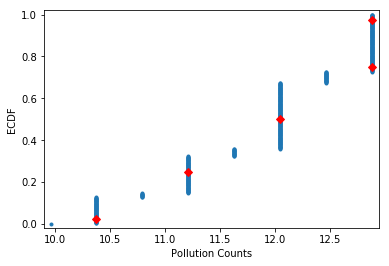

<Figure size 432x288 with 0 Axes>

In [142]:
x = np.sort(air_array)
y = np.arange(1, len(x)+1) / len(x)
_ = plt.plot(x, y, marker='.', linestyle='none')
_ = plt.xlabel('Pollution Counts')
_ = plt.ylabel('ECDF')

# Add percentile markers
percentiles = np.array([2.5,25, 50, 75, 97.5])
ptiles_air = np.percentile(air_array, percentiles)
_ = plt.plot(ptiles_air, percentiles/100, marker='D', color='red',
         linestyle='none')

plt.margins(0.02) # Keeps data off plot edges
plt.show()
plt.savefig('air_pollution_ecdf.png')

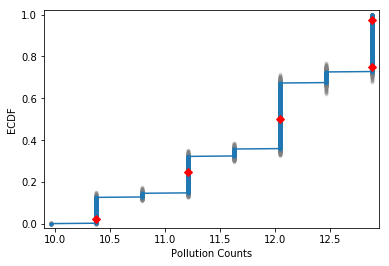

In [143]:
for i in range(50):
    # Generate bootstrap sample:
    bs_sample = np.random.choice(air_array, size=len(air_array))

    # Compute and plot ECDF from bootstrap sample
    x, y = ecdf(bs_sample)
    _ = plt.plot(x, y, marker='.', linestyle='none',
                 color='gray', alpha=0.1)

# Compute and plot ECDF from original data
x, y = ecdf(air_array)
_ = plt.plot(x, y, marker='.')
_ = plt.xlabel('Pollution Counts')
_ = plt.ylabel('ECDF')

# Add percentile markers
percentiles = np.array([2.5,25, 50, 75, 97.5])
ptiles_air = np.percentile(air_array, percentiles)
_ = plt.plot(ptiles_air, percentiles/100, marker='D', color='red',
         linestyle='none')


# Make margins and label axes
plt.margins(0.02)

#### Determine if Air Counts is normally distributed by comparing to theoretical distribution

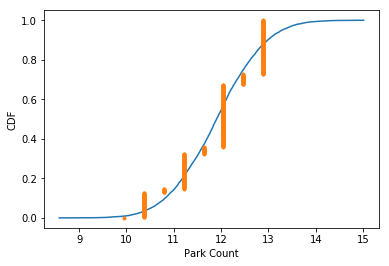

In [149]:
# Compute mean and standard deviation: mu, sigma
mu = np.mean(merged_df_clean_nan["Air Pollution"])
sigma = np.std(merged_df_clean_nan["Air Pollution"])

# Sample out of a normal distribution with this mu and sigma: samples
samples = np.random.normal(mu, sigma, size = 10000)

# Get the CDF of the samples and of the data
x_theor, y_theor = ecdf(samples)
x, y = ecdf(merged_df_clean_nan["Air Pollution"])

# Plot the CDFs and show the plot
_ = plt.plot(x_theor, y_theor)
_ = plt.plot(x, y, marker='.', linestyle='none')
_ = plt.xlabel('Park Count')
_ = plt.ylabel('CDF')
plt.show()

### Distribution of Park Count Data

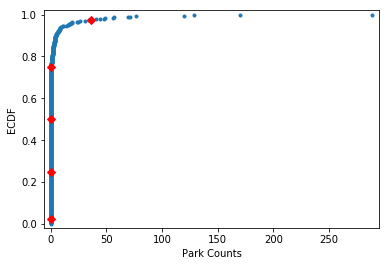

In [144]:
x = np.sort(park_array)
y = np.arange(1, len(x)+1) / len(x)
_ = plt.plot(x, y, marker='.', linestyle='none')
_ = plt.xlabel('Park Counts')
_ = plt.ylabel('ECDF')


# Add percentile markers
percentiles = np.array([2.5, 25, 50, 75, 97.5])
ptiles_park = np.percentile(park_array, percentiles)
_ = plt.plot(ptiles_park, percentiles/100, marker='D', color='red', linestyle='none')

plt.margins(0.02) # Keeps data off plot edges
plt.show()


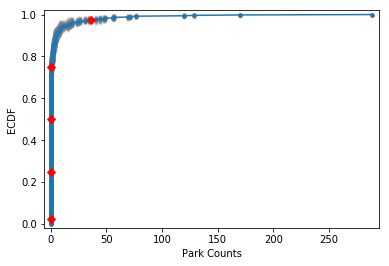

In [145]:
for i in range(50):
    # Generate bootstrap sample:
    bs_sample = np.random.choice(park_array, size=len(park_array))

    # Compute and plot ECDF from bootstrap sample
    x, y = ecdf(bs_sample)
    _ = plt.plot(x, y, marker='.', linestyle='none',
                 color='gray', alpha=0.1)

# Compute and plot ECDF from original data
x, y = ecdf(park_array)
_ = plt.plot(x, y, marker='.')
_ = plt.xlabel('Park Counts')
_ = plt.ylabel('ECDF')

# Add percentile markers
percentiles = np.array([2.5, 25, 50, 75, 97.5])
ptiles_park = np.percentile(park_array, percentiles)
_ = plt.plot(ptiles_park, percentiles/100, marker='D', color='red', linestyle='none')


# Make margins and label axes
plt.margins(0.02)
plt.savefig("park_ecdf.png")

#### Determine if Park Counts is normally distributed by comparing to theoretical distribution

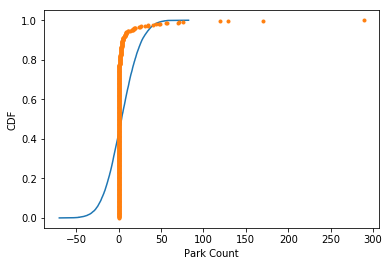

In [150]:
# Compute mean and standard deviation: mu, sigma
mu = np.mean(merged_df_clean_nan["Park Counts"])
sigma = np.std(merged_df_clean_nan["Park Counts"])

# Sample out of a normal distribution with this mu and sigma: samples
samples = np.random.normal(mu, sigma, size = 10000)

# Get the CDF of the samples and of the data
x_theor, y_theor = ecdf(samples)
x, y = ecdf(merged_df_clean_nan["Park Counts"])

# Plot the CDFs and show the plot
_ = plt.plot(x_theor, y_theor)
_ = plt.plot(x, y, marker='.', linestyle='none')
_ = plt.xlabel('Park Count')
_ = plt.ylabel('CDF')
plt.show()

### Distribution of Rent Data

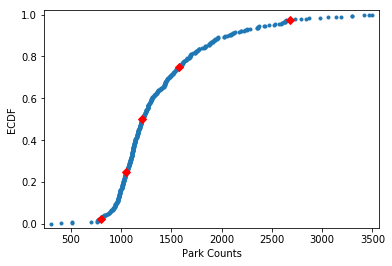

In [146]:
x = np.sort(rent_array)
y = np.arange(1, len(x)+1) / len(x)
_ = plt.plot(x, y, marker='.', linestyle='none')
_ = plt.xlabel('Park Counts')
_ = plt.ylabel('ECDF')

percentiles = np.array([2.5, 25, 50, 75, 97.5])
ptiles_rent = np.percentile(rent_array, percentiles)
_ = plt.plot(ptiles_rent, percentiles/100, marker='D', color='red', linestyle='none')

plt.margins(0.02) # Keeps data off plot edges
plt.show()

### Distribution

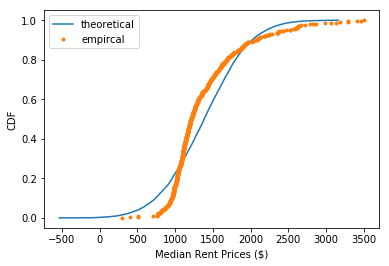

In [147]:
# Compute mean and standard deviation: mu, sigma
mu = np.mean(rent_array)
sigma = np.std(rent_array)

# Sample out of a normal distribution with this mu and sigma: samples
samples = np.random.normal(mu, sigma, size = 10000)

# Get the CDF of the samples and of the data
x_theor, y_theor = ecdf(samples)
x, y = ecdf(rent_array)

# Plot the CDFs and show the plot
_ = plt.plot(x_theor, y_theor)
_ = plt.plot(x, y, marker='.', linestyle='none')
_ = plt.legend(labels = ["theoretical", "empircal"])
_ = plt.xlabel('Median Rent Prices ($)')
_ = plt.ylabel('CDF')
plt.show()

### Visualizing the distribution of the Median Rental Price using Bootstrapping

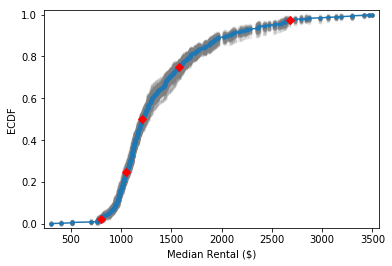

In [148]:
for i in range(50):
    # Generate bootstrap sample:
    bs_sample = np.random.choice(rent_array, size=len(rent_array))

    # Compute and plot ECDF from bootstrap sample
    x, y = ecdf(bs_sample)
    _ = plt.plot(x, y, marker='.', linestyle='none',
                 color='gray', alpha=0.1)

# Compute and plot ECDF from original data
x, y = ecdf(rent_array)
_ = plt.plot(x, y, marker='.')
_ = plt.xlabel('Median Rental ($)')
_ = plt.ylabel('ECDF')

percentiles = np.array([2.5, 25, 50, 75, 97.5])
ptiles_rent = np.percentile(rent_array, percentiles)
_ = plt.plot(ptiles_rent, percentiles/100, marker='D', color='red', linestyle='none')


# Make margins and label axes
plt.margins(0.02)

### Begin Covariance and Pearson correlation coefficient Analysis 

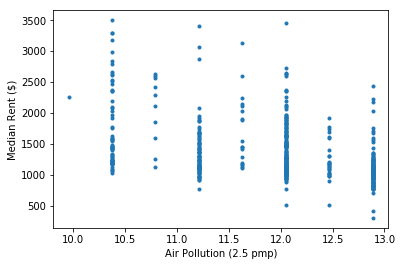

In [151]:
_ = plt.plot(air_array, rent_array, marker='.', linestyle='none')


# Label the axes
_ = plt.ylabel('Median Rent ($)')
_ = plt.xlabel('Air Pollution (2.5 pmp)')

# Show the result
plt.show()

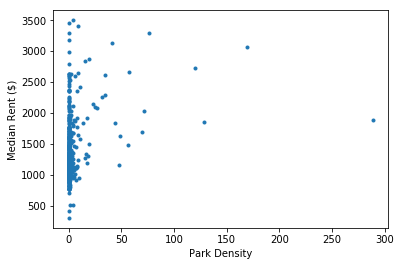

In [152]:
_ = plt.plot(park_array, rent_array, marker='.', linestyle='none')


# Label the axes
_ = plt.ylabel('Median Rent ($)')
_ = plt.xlabel('Park Density')

# Show the result
plt.show()

### Compute the covariance

In [153]:
# Compute the covariance matrix: covariance_matrix
covariance_matrix = np.cov(air_array, rent_array)

# Print covariance matrix
print(covariance_matrix)

# Extract covariance of length and width of petals: petal_cov
rent_air_cov = covariance_matrix[0,1]

# Print the length/width covariance
print(rent_air_cov)

[[ 7.05273837e-01 -1.74143542e+02]
 [-1.74143542e+02  2.52319967e+05]]
-174.1435417495522


In [154]:
# Compute the covariance matrix: covariance_matrix
covariance_matrix = np.cov(park_array, rent_array)

# Print covariance matrix
print(covariance_matrix)

# Extract covariance of length and width of petals: petal_cov
rent_park_cov = covariance_matrix[0,1]

# Print the length/width covariance
print(rent_park_cov)


[[   345.41406121   2555.22988943]
 [  2555.22988943 252319.96748398]]
2555.229889431639


### Computing the Pearson correlation coefficient


In [155]:
def pearson_r(x, y):
    # Compute correlation matrix: corr_mat
    corr_mat = np.corrcoef(x, y)

    # Return entry [0,1]
    return corr_mat[0,1]

In [156]:
# Compute Pearson correlation coefficient for median rent and air quality: r
r = pearson_r(air_array, rent_array)

# Print the result
print(r)


-0.41281234500478764


slope = -246.91620848287596 Median Rental Price ($) / Air pullution (2.5 ppm)
intercept = 4320.66336267108 Median Rental Price ($)


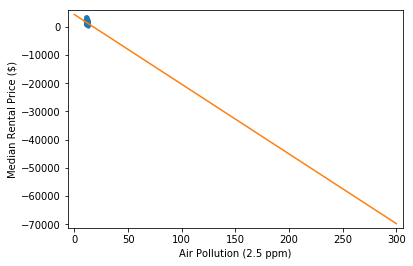

In [157]:
# Plot the median rent $ rate versus air quality
_ = plt.plot(air_array, rent_array, marker='.', linestyle='none')
plt.margins(0.02)
_ = plt.xlabel('Air Pollution (2.5 ppm)')
_ = plt.ylabel('Median Rental Price ($)')

# Perform a linear regression using np.polyfit(): a, b
a, b = np.polyfit(air_array, rent_array, 1)

# Print the results to the screen
print('slope =', a, 'Median Rental Price ($) / Air pullution (2.5 ppm)')
print('intercept =', b, 'Median Rental Price ($)')

# Make theoretical line to plot
x = np.array([0, 300])
y = a * x + b

# Add regression line to your plot
_ = plt.plot(x, y)

# Draw the plot
plt.show()

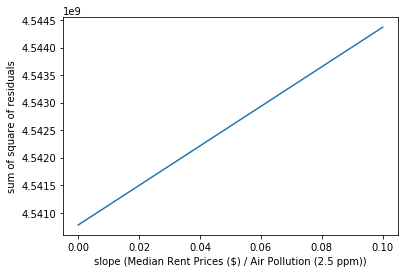

In [158]:
# Determine how optimal is the residual sum of squares

# Specify slopes to consider: a_vals
a_vals = np.linspace(0, 0.1, 200)

# Initialize sum of square of residuals: rss
rss = np.empty_like(a_vals)

# Compute sum of square of residuals for each value of a_vals
for i, a in enumerate(a_vals):
    rss[i] = np.sum((rent_array - a * air_array - b)**2)

# Plot the RSS
plt.plot(a_vals, rss, '-')
plt.xlabel('slope (Median Rent Prices ($) / Air Pollution (2.5 ppm))')
plt.ylabel('sum of square of residuals')

plt.show()


In [159]:
# Compute Pearson correlation coefficient for median rent and park density: r
r = pearson_r(park_array, rent_array)

# Print the result
print(r)

0.27370590206056333


slope = -246.91620848287596 Median Rental Price ($) / Park Counts
intercept = 4320.66336267108 Median Rental Price ($)


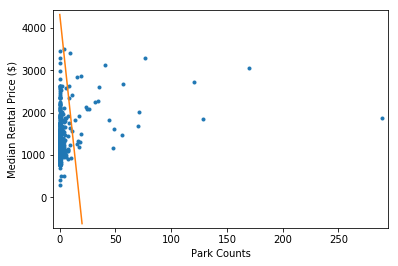

In [160]:
# Plot the air pollution rate versus median rent $
_ = plt.plot(park_array, rent_array, marker='.', linestyle='none')
plt.margins(0.02)
_ = plt.xlabel('Park Counts')
_ = plt.ylabel('Median Rental Price ($)')

# Perform a linear regression using np.polyfit(): a, b
a, b = np.polyfit(air_array, rent_array, 1)

# Print the results to the screen
print('slope =', a, 'Median Rental Price ($) / Park Counts')
print('intercept =', b, 'Median Rental Price ($)')

# Make theoretical line to plot
x = np.array([0, 20])
y = a * x + b

# Add regression line to your plot
_ = plt.plot(x, y)

# Draw the plot
plt.show()

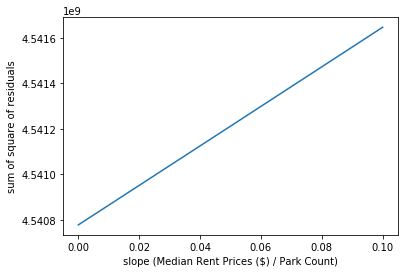

In [161]:
# Determine how optimal is the residual sum of squares

# Specify slopes to consider: a_vals
a_vals = np.linspace(0, 0.1, 200)

# Initialize sum of square of residuals: rss
rss = np.empty_like(a_vals)

# Compute sum of square of residuals for each value of a_vals
for i, a in enumerate(a_vals):
    rss[i] = np.sum((rent_array - a * park_array - b)**2)

# Plot the RSS
plt.plot(a_vals, rss, '-')
plt.xlabel('slope (Median Rent Prices ($) / Park Count)')
plt.ylabel('sum of square of residuals')

plt.show()



### Bootstrapping Functions
* Evaluate the Probability density function using bootstrapping methods
* Evaluate the Probability density function using bootstrapping methods

In [162]:
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

In [163]:
def draw_bs_reps(data, func, size=1):

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates


In [164]:
# This function to be used for linear regression analysis
def draw_bs_pairs_linreg(x, y, size=1):

    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))

    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, 1)

    return bs_slope_reps, bs_intercept_reps


### Bootstrap replicates of the mean and the SEM of the Rent Data

22.19933668371302
22.414751537566108


/anaconda3/envs/PythonData/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


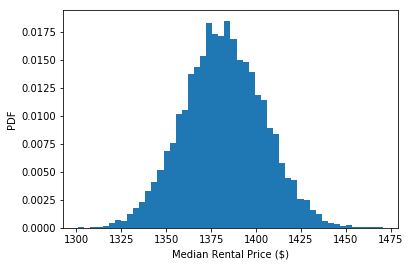

In [165]:
# Take 10,000 bootstrap replicates of the mean: bs_replicates
bs_replicates = draw_bs_reps(rent_array, func = np.mean, size = 10000)

# Compute and print SEM
sem = np.std(rent_array) / np.sqrt(len(rent_array))
print(sem)

# Compute and print standard deviation of bootstrap replicates
bs_std = np.std(bs_replicates)
print(bs_std)

# Make a histogram of the results
_ = plt.hist(bs_replicates, bins=50, normed=True)
_ = plt.xlabel('Median Rental Price ($)')
_ = plt.ylabel('PDF')

# Show the plot
plt.show()

### Bootstrap replicates of the variance for the Rent Data

/anaconda3/envs/PythonData/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


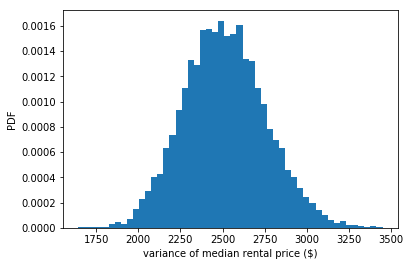

In [166]:
# Generate 10,000 bootstrap replicates of the variance: bs_replicates
bs_replicates = draw_bs_reps(rent_array, func = np.var, size = 10000)

# Put the variance in units of square centimeters
bs_replicates = bs_replicates/100

# Make a histogram of the results
_ = plt.hist(bs_replicates, bins = 50, normed = True)
_ = plt.xlabel('variance of median rental price ($)')
_ = plt.ylabel('PDF')

# Show the plot
plt.show()


### Bootstrap replicates of the mean and the SEM air quality data

0.03711445388806841
0.037186423711226095


/anaconda3/envs/PythonData/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


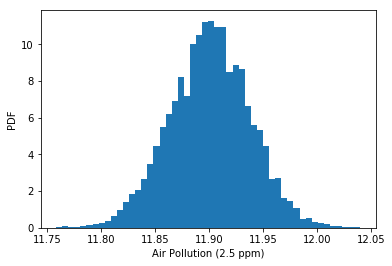

In [167]:
# Take 10,000 bootstrap replicates of the mean: bs_replicates
bs_replicates = draw_bs_reps(air_array, func = np.mean, size = 10000)

# Compute and print SEM
sem = np.std(air_array) / np.sqrt(len(air_array))
print(sem)

# Compute and print standard deviation of bootstrap replicates
bs_std = np.std(bs_replicates)
print(bs_std)

# Make a histogram of the results
_ = plt.hist(bs_replicates, bins=50, normed=True)
_ = plt.xlabel('Air Pollution (2.5 ppm)')
_ = plt.ylabel('PDF')

# Show the plot
plt.show()

### Bootstrap replicates of the variance for the Air Pollution Data

/anaconda3/envs/PythonData/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


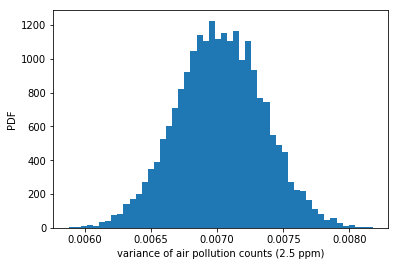

In [168]:
# Generate 10,000 bootstrap replicates of the variance: bs_replicates
bs_replicates = draw_bs_reps(air_array, func = np.var, size = 10000)

# Put the variance in units of square centimeters
bs_replicates = bs_replicates/100

# Make a histogram of the results
_ = plt.hist(bs_replicates, bins = 50, normed = True)
_ = plt.xlabel('variance of air pollution counts (2.5 ppm)')
_ = plt.ylabel('PDF')

# Show the plot
plt.show()



### Bootstrap replicates of the mean and the SEM of the Park Data

0.821361220589279
0.8091543811428569


/anaconda3/envs/PythonData/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


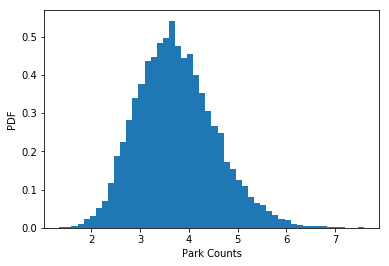

In [169]:
# Take 10,000 bootstrap replicates of the mean: bs_replicates
bs_replicates = draw_bs_reps(park_array, func = np.mean, size = 10000)

# Compute and print SEM
sem = np.std(park_array) / np.sqrt(len(park_array))
print(sem)

# Compute and print standard deviation of bootstrap replicates
bs_std = np.std(bs_replicates)
print(bs_std)

# Make a histogram of the results
_ = plt.hist(bs_replicates, bins=50, normed=True)
_ = plt.xlabel('Park Counts')
_ = plt.ylabel('PDF')

# Show the plot
plt.show()

### Bootstrap replicates of the variance for the Park Pollution Data

/anaconda3/envs/PythonData/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


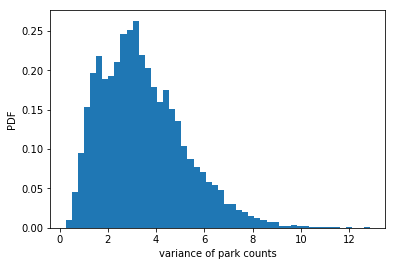

In [170]:
# Generate 10,000 bootstrap replicates of the variance: bs_replicates
bs_replicates = draw_bs_reps(park_array, func = np.var, size = 10000)

# Put the variance in units of square centimeters
bs_replicates = bs_replicates/100

# Make a histogram of the results
_ = plt.hist(bs_replicates, bins = 50, normed = True)
_ = plt.xlabel('variance of park counts')
_ = plt.ylabel('PDF')

# Show the plot
plt.show()




### Linear Regressions

In [171]:
# This function to be used for linear regression analysis
def draw_bs_pairs_linreg(x, y, size=1):

    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))

    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, 1)

    return bs_slope_reps, bs_intercept_reps

### Generate permutations from two samples
* To test the hypothesis that two variables have identical probability distributions

In [172]:
def permutation_sample(data1, data2):

    # Concatenate the data sets: data
    data = np.concatenate((data1, data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

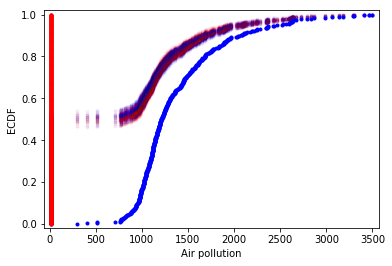

In [173]:
for i in range(50):
    # Generate permutation samples
    perm_sample_1, perm_sample_2 = permutation_sample(air_array, rent_array)


    # Compute ECDFs
    x_1, y_1 = ecdf(perm_sample_1)
    x_2, y_2 = ecdf(perm_sample_2)

    # Plot ECDFs of permutation sample
    _ = plt.plot(x_1, y_1, marker='.', linestyle='none',
                 color='red', alpha=0.02)
    _ = plt.plot(x_2, y_2, marker='.', linestyle='none',
                 color='blue', alpha=0.02)

# Create and plot ECDFs from original data
x_1, y_1 = ecdf(air_array)
x_2, y_2 = ecdf(rent_array)
_ = plt.plot(x_1, y_1, marker='.', linestyle='none', color='red')
_ = plt.plot(x_2, y_2, marker='.', linestyle='none', color='blue')

# Label axes, set margin, and show plot
plt.margins(0.02)
_ = plt.xlabel('Air pollution')
_ = plt.ylabel('ECDF')
plt.show()

#### None of the ECDFs from the permutation samples overlap with the observed data, suggesting that the hypothesis is not commensurate with the data. Air pollution and median rain price are not identically distributed.

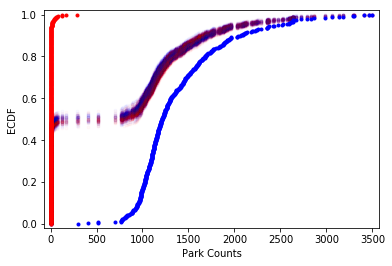

In [174]:
for i in range(50):
    # Generate permutation samples
    perm_sample_1, perm_sample_2 = permutation_sample(park_array, rent_array)


    # Compute ECDFs
    x_1, y_1 = ecdf(perm_sample_1)
    x_2, y_2 = ecdf(perm_sample_2)

    # Plot ECDFs of permutation sample
    _ = plt.plot(x_1, y_1, marker='.', linestyle='none',
                 color='red', alpha=0.02)
    _ = plt.plot(x_2, y_2, marker='.', linestyle='none',
                 color='blue', alpha=0.02)

# Create and plot ECDFs from original data
x_1, y_1 = ecdf(park_array)
x_2, y_2 = ecdf(rent_array)
_ = plt.plot(x_1, y_1, marker='.', linestyle='none', color='red')
_ = plt.plot(x_2, y_2, marker='.', linestyle='none', color='blue')

# Label axes, set margin, and show plot
plt.margins(0.02)
_ = plt.xlabel('Park Counts')
_ = plt.ylabel('ECDF')
plt.show()

#### None of the ECDFs from the permutation samples overlap with the observed data, suggesting that the hypothesis is not commensurate with the data. Air pollution and median rain price are not identically distributed.

### Generating permutation replicates

In [175]:
def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates

In [200]:
X = merged_df_clean_nan[['Air Pollution', 'Park Counts']]
y = rent_array

# Fit and make the predictions by the model
model = sm.OLS(y, X).fit()
predictions = model.predict(X)

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Median Rent   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     1724.
Date:                Fri, 01 Mar 2019   Prob (F-statistic):          2.20e-227
Time:                        21:34:22   Log-Likelihood:                -3928.0
No. Observations:                 511   AIC:                             7860.
Df Residuals:                     509   BIC:                             7869.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Air Pollution   111.8905      1.996     56.054      0.000     107.969     115.812
Park Counts       8.1625      1.257      6.493      0.000       5.693      10.632
==============================================================================
Omnibus:                      130.518   Durbin-Watson:                   2.124
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              297.637
Skew:                           1.326   Prob(JB):                     2.34e-65
Kurtosis:                       5.636   Cond. No.                         1.65
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Analysis is covariances & Linear Regressions

In [181]:
# Create arrays for features and target variable
y = merged_df_clean_nan['Median Rent'].values
X = merged_df_clean_nan['Air Pollution'].values

# Print the dimensions of X and y before reshaping
print("Dimensions of y before reshaping: {}".format(y.shape))
print("Dimensions of X before reshaping: {}".format(X.shape))

# Reshape X and y
y = y.reshape(-1, 1)
X = X.reshape(-1, 1)

# Print the dimensions of X and y after reshaping
print("Dimensions of y after reshaping: {}".format(y.shape))
print("Dimensions of X after reshaping: {}".format(X.shape))


Dimensions of y before reshaping: (511,)
Dimensions of X before reshaping: (511,)
Dimensions of y after reshaping: (511, 1)
Dimensions of X after reshaping: (511, 1)


In [183]:
merged_df_clean_nan.columns

Index(['Neighborhood', 'Lat', 'Lng', 'Median Rent', 'Air Pollution',
       'Park Counts', 'tract number', 'Location'],
      dtype='object')

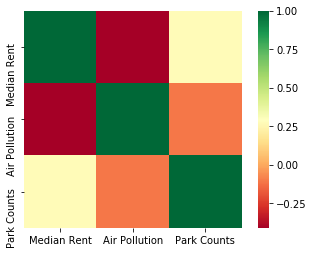

In [184]:
short_merged_df = merged_df_clean_nan[['Neighborhood', 'Median Rent', 'Air Pollution', 'Park Counts']]
sns.heatmap(short_merged_df.corr(), square=True, cmap='RdYlGn')
plt.savefig('air_park_rent_correlation.png')

In [186]:
print(short_merged_df.corr())

               Median Rent  Air Pollution  Park Counts
Median Rent       1.000000      -0.412812     0.273706
Air Pollution    -0.412812       1.000000    -0.108068
Park Counts       0.273706      -0.108068     1.000000


The R^2: 0.17041403218835172


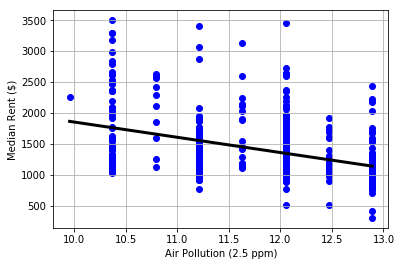

In [188]:
# Create the regressor: reg
reg = LinearRegression()

# Create the prediction space
prediction_space = np.linspace(min(X), max(X)).reshape(-1,1)

# Fit the model to the data
reg.fit(X, y)

# Compute predictions over the prediction space: y_pred
y_pred = reg.predict(prediction_space)

# Print R^2 
print(f"The R^2: {reg.score(X, y)}")

# Plot regression line
plt.scatter(X, y, color = "blue")
plt.plot(prediction_space, y_pred, color='black', linewidth=3)
plt.xlabel("Air Pollution (2.5 ppm)")
plt.ylabel("Median Rent ($)")
plt.grid()
plt.show()


#### Train/test split for regression
* Dataset is split into training and testing sets, and then fit and predict a linear regression over all features. 
* In addition to computing the R2, also compute the Root Mean Squared Error (RMSE)
* RMSE is used to evaluate regression models.

In [189]:

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# Create the regressor: reg_all
reg_all = LinearRegression()

# Fit the regressor to the training data
reg_all.fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred = reg_all.predict(X_test)

# Compute and print R^2 and RMSE
print("R^2: {}".format(reg_all.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))


R^2: 0.12938028962287118
Root Mean Squared Error: 446.17211242367694


In [190]:
# Create a linear regression object: reg
reg = LinearRegression()

# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(reg, X, y, cv = 5)

# Print the 5-fold cross-validation scores
print(cv_scores)

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))


[ 0.18213306 -0.00414782  0.20482976  0.13353362  0.18199011]
Average 5-Fold CV Score: 0.1396677465580292


### Linear Regression for Parks

In [191]:
# Create arrays for features and target variable
y = merged_df_clean_nan['Median Rent'].values
Xp = merged_df_clean_nan['Park Counts'].values

# Print the dimensions of X and y before reshaping
print("Dimensions of y before reshaping: {}".format(y.shape))
print("Dimensions of X before reshaping: {}".format(Xp.shape))

# Reshape X and y
y = y.reshape(-1, 1)
Xp = Xp.reshape(-1, 1)

# Print the dimensions of X and y after reshaping
print("Dimensions of y after reshaping: {}".format(y.shape))
print("Dimensions of X after reshaping: {}".format(Xp.shape))



Dimensions of y before reshaping: (511,)
Dimensions of X before reshaping: (511,)
Dimensions of y after reshaping: (511, 1)
Dimensions of X after reshaping: (511, 1)


The R^2: 0.07491492082278683


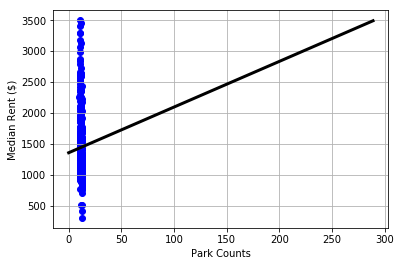

In [192]:
# Create the regressor: reg
reg = LinearRegression()

# Create the prediction space
prediction_space = np.linspace(min(Xp), max(Xp)).reshape(-1,1)

# Fit the model to the data
reg.fit(Xp, y)

# Compute predictions over the prediction space: y_pred
y_pred = reg.predict(prediction_space)

# Print R^2 
print(f"The R^2: {reg.score(Xp, y)}")

# Plot regression line
plt.scatter(X, y, color = "blue")
plt.plot(prediction_space, y_pred, color='black', linewidth=3)
plt.xlabel("Park Counts")
plt.ylabel("Median Rent ($)")
plt.grid()
plt.show()


## Lavene's Test

In [131]:
# Test if the variances of these variables are significantly different
air_pol = np.array(df["count"])
air_merged = np.array(air_array)

t, p = levene(air_pol, air_merged)
print("statistic: t = %g  p = %g" % (t, p))

statistic: t = 0.205945  p = 0.650004


In [132]:
#  Determine if downsampling significantly changed 
# the mean of the air pollution counts using ttest

# Use scipy.stats.ttest_ind.
t, p = ttest_ind(air_pol, air_merged, equal_var=True)
print("ttest_ind: t = %g  p = %g" % (t, p))

ttest_ind: t = -0.138705  p = 0.889694


In [135]:
# Test if the variances of these variables are significantly different
park_count = np.array(df_park["count"])
park_merged = np.array(park_array)

t, p = levene(air_pol, air_merged)
print("statistic: t = %g  p = %g" % (t, p))

statistic: t = 0.205945  p = 0.650004


## T test for 2 indipendent samples: determine means differ between downsampled and original dataset

In [136]:
#  Determine if downsampling significantly changed 
# the mean of the Park counts

# Use scipy.stats.ttest_ind.
t, p = ttest_ind(park_count, park_merged, equal_var=True)
print("ttest_ind: t = %g  p = %g" % (t, p))

ttest_ind: t = 1.5198  p = 0.128772


In [137]:
# Test if the variances of these variables are significantly different
rent_rates = np.array(rent_df["Median Rent"])
rent_merged = np.array(rent_array)

t, p = levene(air_pol, air_merged)
print("statistic: t = %g  p = %g" % (t, p))

statistic: t = 0.205945  p = 0.650004


In [138]:
#  Determine if downsampling significantly changed 
# the mean of the Rent Data

# Use scipy.stats.ttest_ind.
t, p = ttest_ind(rent_rates, rent_merged, equal_var=False)
print("ttest_ind: t = %g  p = %g" % (t, p))

ttest_ind: t = 1.53738  p = 0.12463
